<a href="https://colab.research.google.com/github/andreaaraldo/mining-low-dim-network-data/blob/master/BarcelonaCourse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook has been forked from the [repository of Prof. Marc Crovella](https://github.com/mcrovella/mining-low-dim-network-data), Boston University, and modified by Andrea Araldo.


In [43]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# import libraries
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
print('')

from sklearn.preprocessing import StandardScaler

## Empirical Evidence

Let's see how dimensionality reduction can be used in practice, and investigate some real data.

We'll look at OD flow traffic on the Abilene network:

<img src='https://github.com/andreaaraldo/mining-low-dim-network-data/blob/master/images/Abilene-map.png?raw=1'>

Source: Internet2, circa 2005

*Araldo*:
We now donwload the data from the repository of Marc Crovella. The commands are inspired by [this post](https://github.community/t5/How-to-use-Git-and-GitHub/How-can-I-download-a-specific-folder-from-a-GitHub-repo/m-p/95/highlight/true#M23).

In [44]:
! mkdir data
! cd data
! git init
! git remote add origin -f https://github.com/mcrovella/mining-low-dim-network-data
! echo "data" > .git/info/sparse-checkout
! git pull origin master

with open('data/net-traffic/AbileneFlows/odnames','r') as f:
    odnames = [line.strip() for line in f]

Xtraf_orig = pd.read_table('data/net-traffic/AbileneFlows/X',sep='  ',header=None,
                      names=odnames,engine='python')

mkdir: cannot create directory ‘data’: File exists
Reinitialized existing Git repository in /content/.git/
error: remote origin already exists.
From https://github.com/mcrovella/mining-low-dim-network-data
 * branch            master     -> FETCH_HEAD
Already up to date.


*Araldo*:
We know from the description of the dataset, that each sample represents a period of 10 min and that we have 1 week measurements (and thus we have 1008 periods in total). We can thus index the dataset, with the corresponding column of time-stamps. To do so, we first create the vector `dates`, and then we set it as the index of the dataframe.

*Araldo*: Each column counts the amount of bytes flowing between a pair of nodes.

In [45]:
dates = pd.date_range('9/1/2003',freq='10min',periods=1008)

Xtraf_orig.index = dates
Xtraf_orig

,ATLA-ATLA,ATLA-CHIN,ATLA-DNVR,ATLA-HSTN,ATLA-IPLS,ATLA-KSCY,ATLA-LOSA,ATLA-NYCM,ATLA-SNVA,ATLA-STTL,...,WASH-CHIN,WASH-DNVR,WASH-HSTN,WASH-IPLS,WASH-KSCY,WASH-LOSA,WASH-NYCM,WASH-SNVA,WASH-STTL,WASH-WASH
2003-09-01 00:00:00,8466132.0,29346537.0,15792104.0,3646187.0,21756443.0,10792818.0,14220940.0,25014340.0,13677284.0,10591345.0,...,53296727.0,18724766.0,12238893.0,52782009.0,12836459.0,31460190.0,105796930.0,13756184.0,13582945.0,120384980.0
2003-09-01 00:10:00,20524567.0,28726106.0,8030109.0,4175817.0,24497174.0,8623734.0,15695839.0,36788680.0,5607086.0,10714795.0,...,68413060.0,28522606.0,11377094.0,60006620.0,12556471.0,32450393.0,70665497.0,13968786.0,16144471.0,135679630.0
2003-09-01 00:20:00,12864863.0,27630217.0,7417228.0,5337471.0,23254392.0,7882377.0,16176022.0,31682355.0,6354657.0,12205515.0,...,67969461.0,37073856.0,15680615.0,61484233.0,16318506.0,33768245.0,71577084.0,13938533.0,14959708.0,126175780.0
2003-09-01 00:30:00,10856263.0,32243146.0,7136130.0,3695059.0,28747761.0,9102603.0,16200072.0,27472465.0,9402609.0,10934084.0,...,66616097.0,43019246.0,12726958.0,64027333.0,16394673.0,33440318.0,79682647.0,16212806.0,16425845.0,112891500.0
2003-09-01 00:40:00,10068533.0,30164311.0,8061482.0,2922271.0,35642229.0,9104036.0,12279530.0,29171205.0,7624924.0,11327807.0,...,66797282.0,40408580.0,11733121.0,54541962.0,16769259.0,33927515.0,81480788.0,16757707.0,15158825.0,123140310.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003-09-07 23:10:00,8849096.0,33461807.0,5866138.0,3786793.0,19097140.0,10561532.0,26092040.0,28640962.0,8343867.0,8820650.0,...,65925313.0,21751316.0,11058944.0,58591021.0,17137907.0,24297674.0,83293655.0,17329425.0,20865535.0,123125390.0
2003-09-07 23:20:00,9776675.0,31474607.0,5874654.0,11277465.0,14314837.0,9106198.0,26412752.0,26168288.0,8638782.0,9193717.0,...,70075490.0,29126443.0,12667321.0,54571764.0,15383038.0,25238842.0,70015955.0,16526455.0,16881206.0,142106800.0
2003-09-07 23:30:00,9144621.0,32117262.0,5762691.0,7154577.0,17771350.0,10149256.0,29501669.0,25998158.0,11343171.0,9423042.0,...,68544458.0,27817836.0,15892668.0,50326213.0,12098328.0,27689197.0,73553203.0,18022288.0,18471915.0,127918530.0
2003-09-07 23:40:00,8802106.0,29932510.0,5279285.0,5950898.0,20222187.0,10636832.0,19613671.0,26124024.0,8732768.0,8217873.0,...,65087776.0,28836922.0,11075541.0,52574692.0,11933512.0,31632344.0,81693475.0,16677568.0,16766967.0,138180630.0


In [46]:
scaler = StandardScaler()
scaler.fit(Xtraf_orig)
Xtraf = scaler.transform(Xtraf_orig)

*Araldo*:
The function `np.linalg.svd(..)` performs Singular Value Decomposition.

The  121  singular values are
[213.24422348  94.81864184  72.01879866  60.08516091  49.78297799
  46.04289805  45.97542917  44.6870501   41.65725799  40.26760699
  37.71419945  37.12599697  36.62474566  36.07052248  34.1404179
  33.83459972  33.32379033  32.52122656  31.76123014  31.62667331
  30.91265187  30.64668453  29.64208261  29.22226209  28.72139625
  28.46749078  28.16127816  27.82451733  27.27872342  27.09413535
  26.43695272  26.34852742  26.11987423  25.80985921  25.17828669
  24.93629462  24.75126498  24.02005546  23.69745006  23.53326355
  23.48543788  23.19261773  23.05987571  22.81487219  22.4905061
  22.2162455   21.93742571  21.67433964  21.463087    21.27722071
  21.12762916  20.98502766  20.78162873  20.41838461  19.9045955
  19.65191397  19.43963327  19.21177175  19.0924894   18.86579456
  18.47220105  18.16521692  18.12756767  18.00383291  17.78258551
  17.5861231   17.38779473  17.2374608   16.88489253  16.53502142
  16.5150157   16.22426304  16.2019762   16.03286

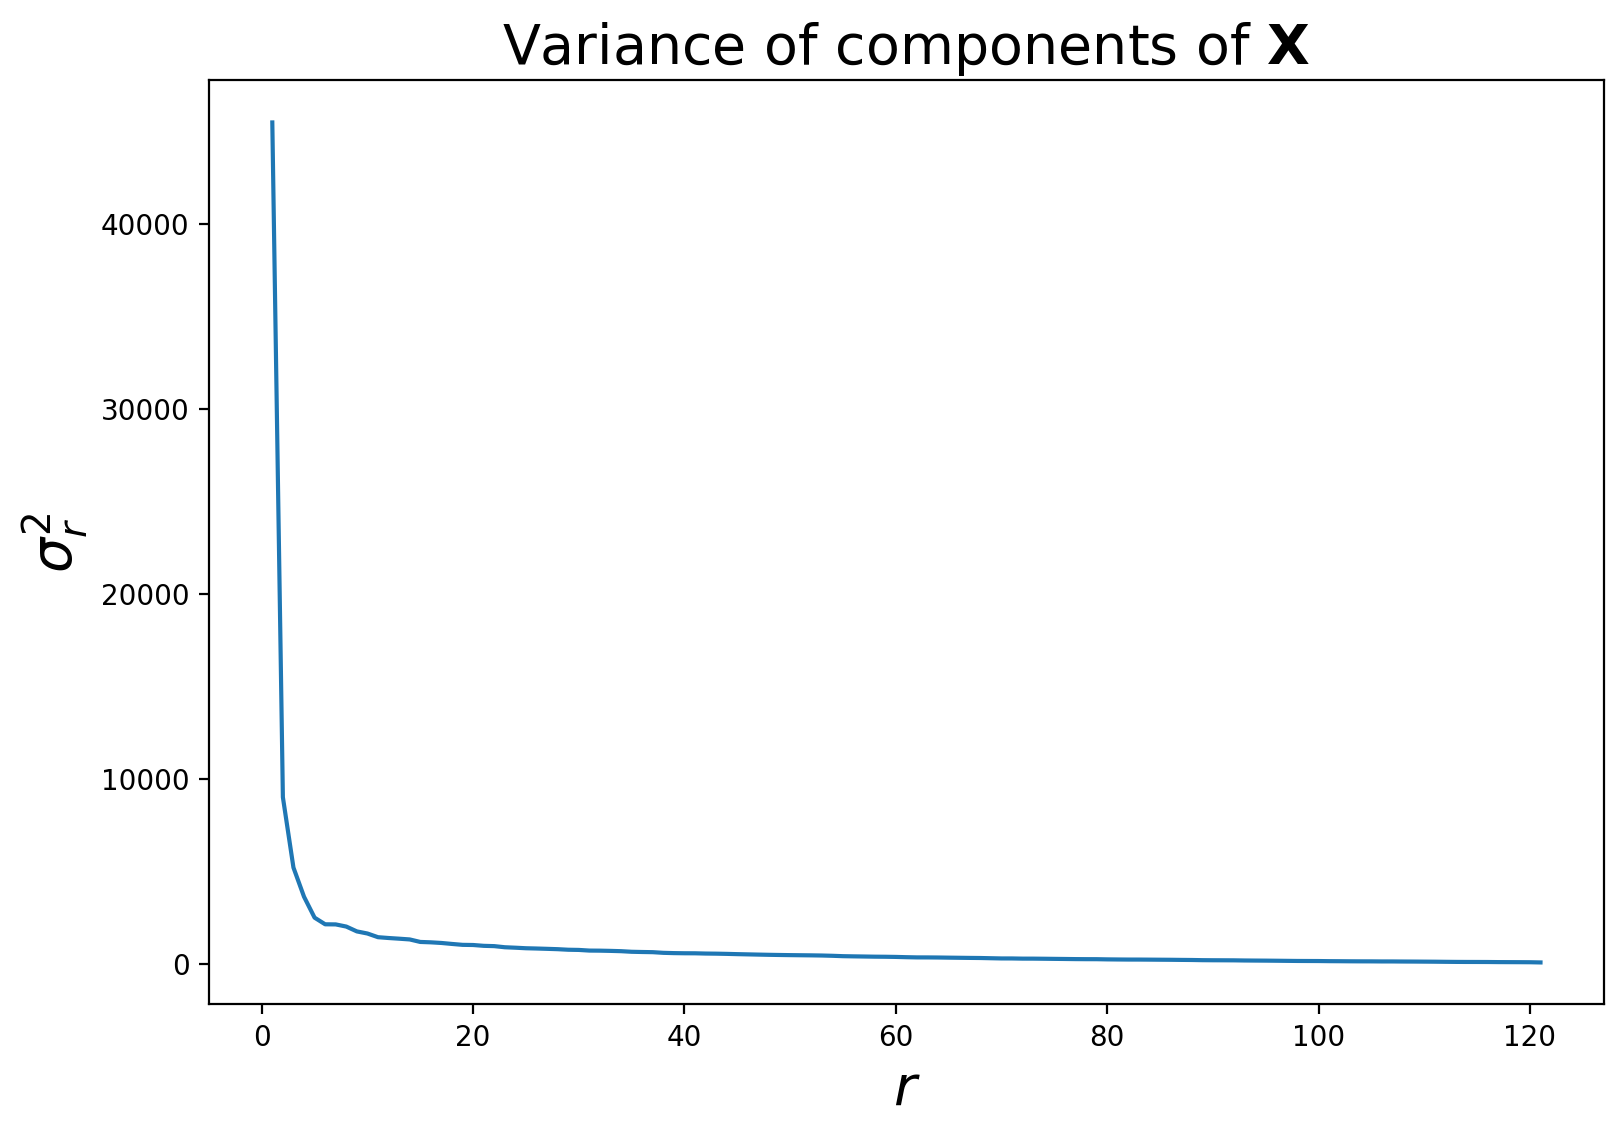

In [47]:
U,Sigma,Vt = np.linalg.svd(Xtraf,full_matrices=False)

print("The ", len(Sigma), " singular values are")
print(Sigma)

Sigma_squared = np.square(Sigma)

### Plotting
print("\n The variances of the principal components are")
fig = plt.figure(figsize=(9,6))
plt.plot(range(1,1+len(Sigma_squared)),Sigma_squared)
plt.xlabel(r'$r$',size=20)
plt.ylabel(r'$\sigma_r^2$',size=20)
plt.title(r'Variance of components of $\mathbf{X}$',size=20)
print('')

The variance captured by keeping $r$ principal component is

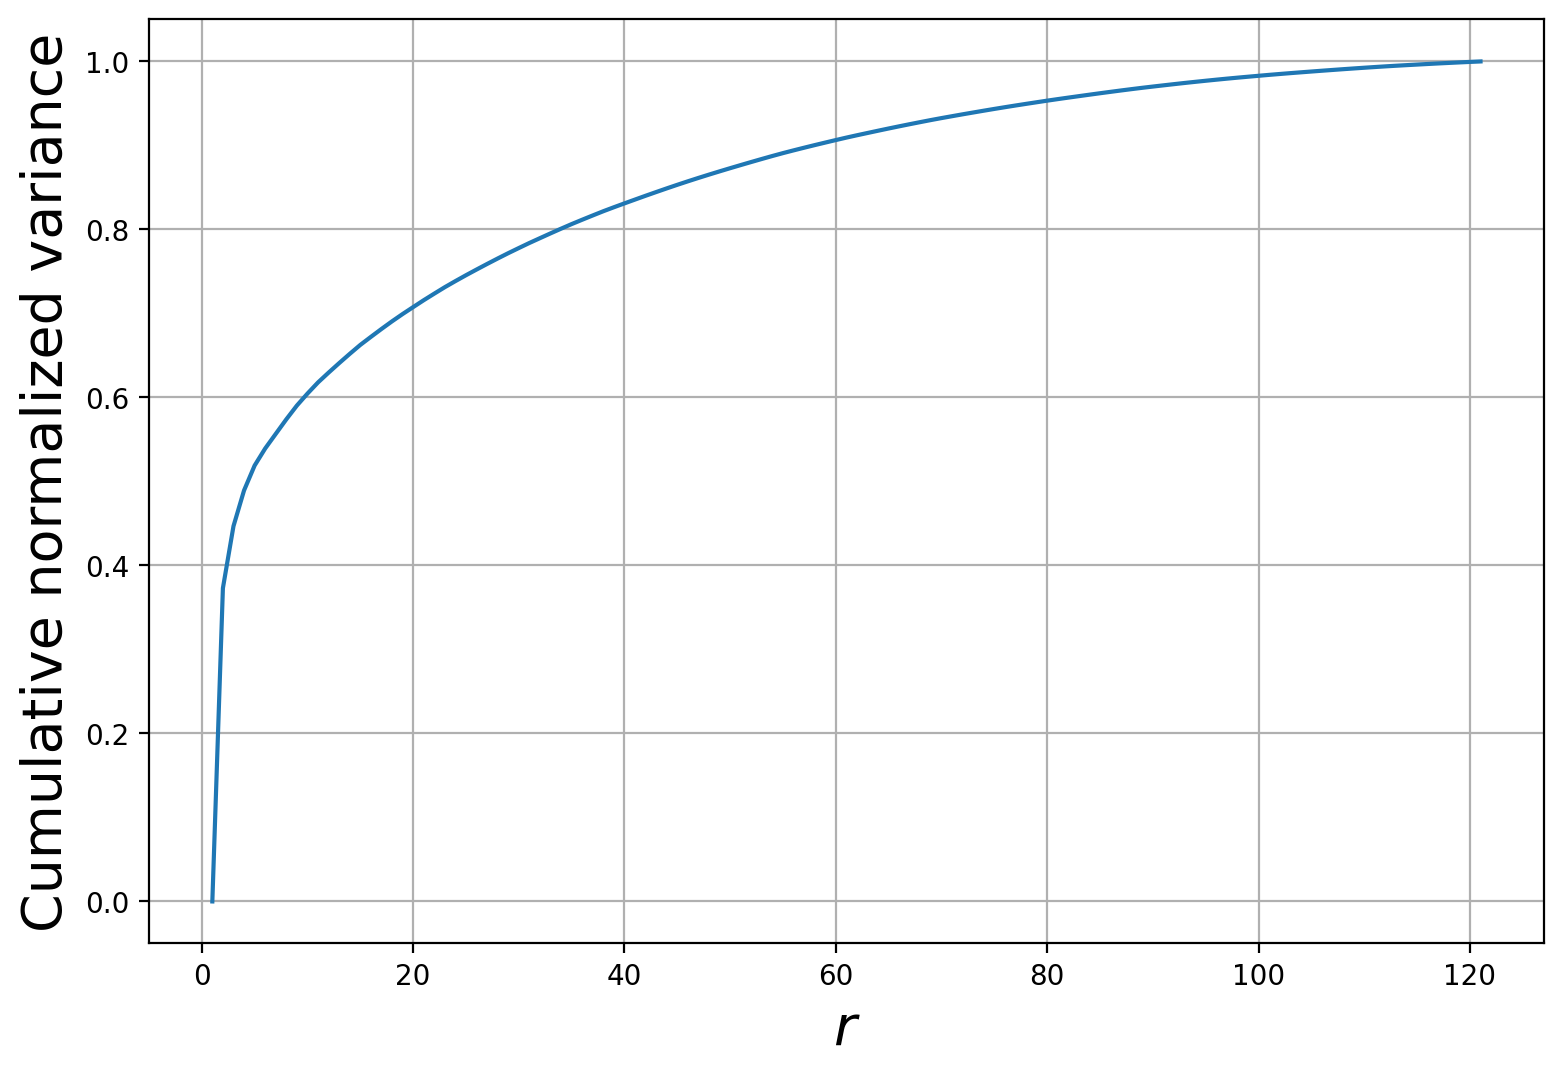

In [48]:
total_variance = total_variance = sum(Sigma_squared)
cumul = [ sum(Sigma_squared[0:i]/total_variance) for i in range(len(Sigma_squared))]

### Plotting
fig = plt.figure(figsize=(9,6))
plt.plot(range(1,1+len(cumul)),cumul)
plt.xlabel(r'$r$',size=20)
plt.ylabel(r'Cumulative normalized variance',size=20)
plt.grid(visible=True)

# Anomaly Detection via the Low-Dimensional Phenomenon

We can use dimensionality reduction to perform anomaly detection in an unsupervised way (no need for labeled data)

In practice, given a set of measurements:

* Assume that “most” observations are normal
* Build a low-dimensional (linear) model for them
* What is not well predicted is anomalous and most likely some form of misbehavior


In practice, this is a simple process.

Given a data matrix $\mathbf{X}$:

1.  Compute the Singular value decomposition of $\mathbf{X}$, $$\mathbf{U}\mathbf{\Sigma} \mathbf{V}^T = \mathbf{X}.$$
2.  Compute a low-rank approximation of $\mathbf{X}$ (not the reduced matrix!), using only $r$ components: $$\mathbf{L} = \mathbf{U}_r \cdot \mathbf{\Sigma}_r \cdot \mathbf{V}_r^T.$$
3.  Compute the information not captured by $\mathbf{L}$:  $$\mathbf{O} = \mathbf{X}-\mathbf{L}.$$

4. We assume the "normal" information is contained in the low rank approximation $\mathbf{L}$, while anomalies are what cannot be captured by the low-rank approximation, i.e., $\mathbf{O}$

5.  Indentify the rows of $\mathbf{O}$ with largest $\ell_2$ (Euclidean) norm: these rows correspond to the anomalous samples. In other words, the Euclidean norm of each row of $\mathbf{O}$ is its anomaly score of the corresponding sample.

There are two unspecified steps in the process:

1. Selecting the number of components $r$.
2. Deciding how many of the largest rows of $\mathbf{O}$ are anomalies.

For 1, the general idea is to choose a $r$ at the knee of the principal component variance plot.  
For 2, we can plot the Precision-Recall and ROC curves and decide a threshold based on that (see [my other code](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.b.isolation-forest.ipynb)).

### Example 1: Traffic OD Flows

This data consists of the number of bytes flowing between 121 origin-destination pairs in the Abilene network, sampled at 10 minute intervals, for one week.

Rows (samples) are timebins, Columns are source-destination pairs.

We want to find timeslots in which an anomaly has occurred.

In [49]:
r=6 # Number of components

U_r = U[:,0:r]
Sigma_r = np.diag(Sigma[0:r])
V_r_t = Vt[0:r,:]

Ltraf = np.dot(U_r, np.dot(Sigma_r, V_r_t) )

print ("Ltraf", Ltraf.shape)
print ("Xtraf", Xtraf.shape)

Otraf = Xtraf - Ltraf # Line i of this matrix is the "anomalousness" of the i-th
                      # timeslot.

# For each time-slot, it quantifies the "amount of anormality"
anomaly_scores = np.linalg.norm(Otraf,axis=1)

Ltraf (1008, 121)
Xtraf (1008, 121)


Now we'll choose the top 15 anomalous time points and look at where they fall.

In [50]:
# choose the top 15 anomalous time intervals
anomalies = np.argsort(anomaly_scores)[-15:]

Let's plot the curve of total traffic and let us add the anomaly as points on top of this curve.

Text(0, 0.5, 'Volume total du trafic')

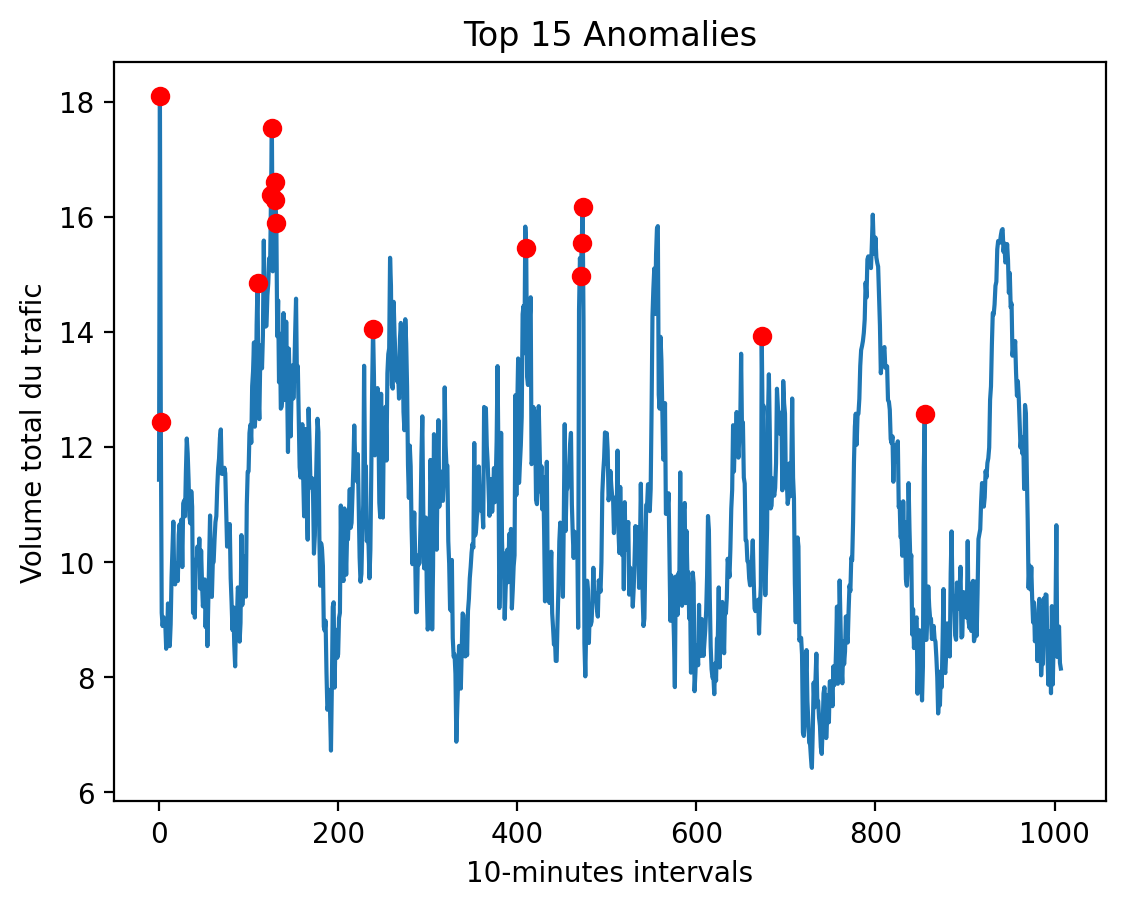

In [51]:


### Plotting
Xnorm = np.linalg.norm(Xtraf,axis=1)
plt.plot(Xnorm)

# Them, plot a circle per each anomalous time interval
plt.plot(anomalies,Xnorm[anomalies],'ro')
plt.title('Top 15 Anomalies')
plt.xlabel('10-minutes intervals')
plt.ylabel('Volume total du trafic')

Observe that these anomalies were **hidden**, i.e., they are not easily observable just by looking at the norm of the original traffic matrix over time.

In order to unveil such anomalies, we had to get the "normal" behavior via Dimensionality Reduction and define all that is left out (`Otraf`) as anomaly. Note that the power of Dimensionality Reduction is that it is able to consider the evolution of all OD flows jointly, and not only the evolution of the traffic matrix norm.

### Example 2: Facebook Spatial Likes

We want to recognize "fake" users, i.e., profiles created (or legitimate profiles compromised) with the objective to perform malicious activity, as artificially increasing the number of likes of certain pages, which may pay for this kind of "service" to gain popularity [1].

This data consists of the number of 'Likes' for each of 9000 users, over 6 months, across the 210 content categories that Facebook assigns to pages.

**Rows are users**, **columns are content categories**.

The goal is to find anomalous users.

In [52]:
data = np.loadtxt('data/social/data/spatial_data.txt')
FBSpatial_orig = data[:,1:] # The first column is not a category, we remove it


scaler = StandardScaler()
scaler.fit(FBSpatial_orig)
FBSpatial = scaler.transform(FBSpatial_orig)



print(FBSpatial)
print(FBSpatial.shape)

[[-0.14103401 -0.05635879 -0.26679811 ... -0.05636389 -0.26638064
  -0.20526228]
 [-0.14103401 -0.05635879 -0.26679811 ... -0.05636389 -0.26638064
  -0.20526228]
 [-0.14103401 -0.05635879 -0.26679811 ... -0.05636389  2.04422384
   0.50692152]
 ...
 [-0.14103401 -0.05635879 -0.26679811 ... -0.05636389 -0.26638064
  -0.20526228]
 [-0.14103401 -0.05635879 -0.26679811 ... -0.05636389 -0.26638064
  -0.20526228]
 [-0.14103401 -0.05635879 -0.26679811 ... -0.05636389 -0.26638064
  -0.20526228]]
(8982, 210)


There are 8982 users and 211 categories

First we'll look at the total number of likes for each user (the row sums).

Text(0, 0.5, 'Total number of likes')

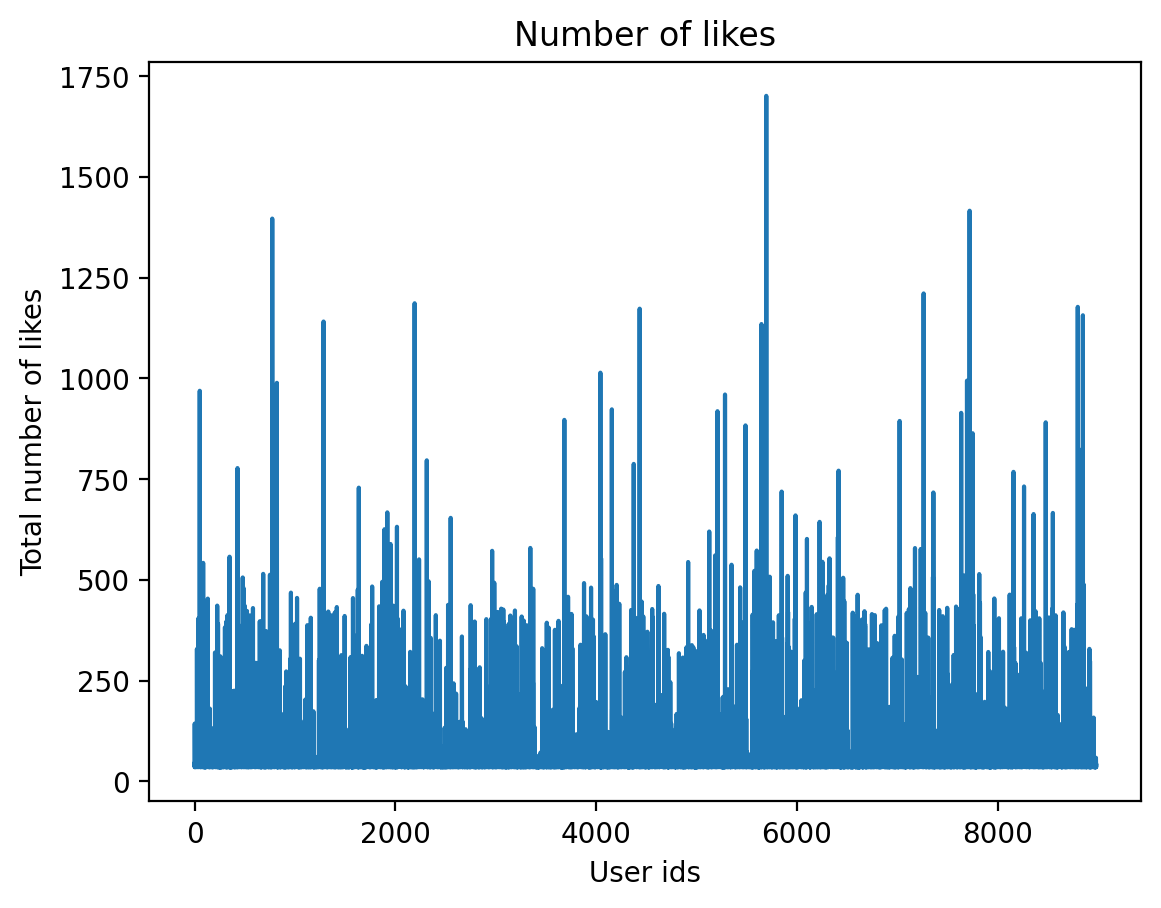

In [53]:
FBSnorm = np.linalg.norm(FBSpatial,axis=1,ord=1)

### Plot
plt.plot(FBSnorm)
plt.title('Number of likes')
plt.xlabel('User ids')
plt.ylabel('Total number of likes')

Now let's check whether we can compress the information of the dataset in few components

Text(0, 0.5, '$\\sigma_r^2$')

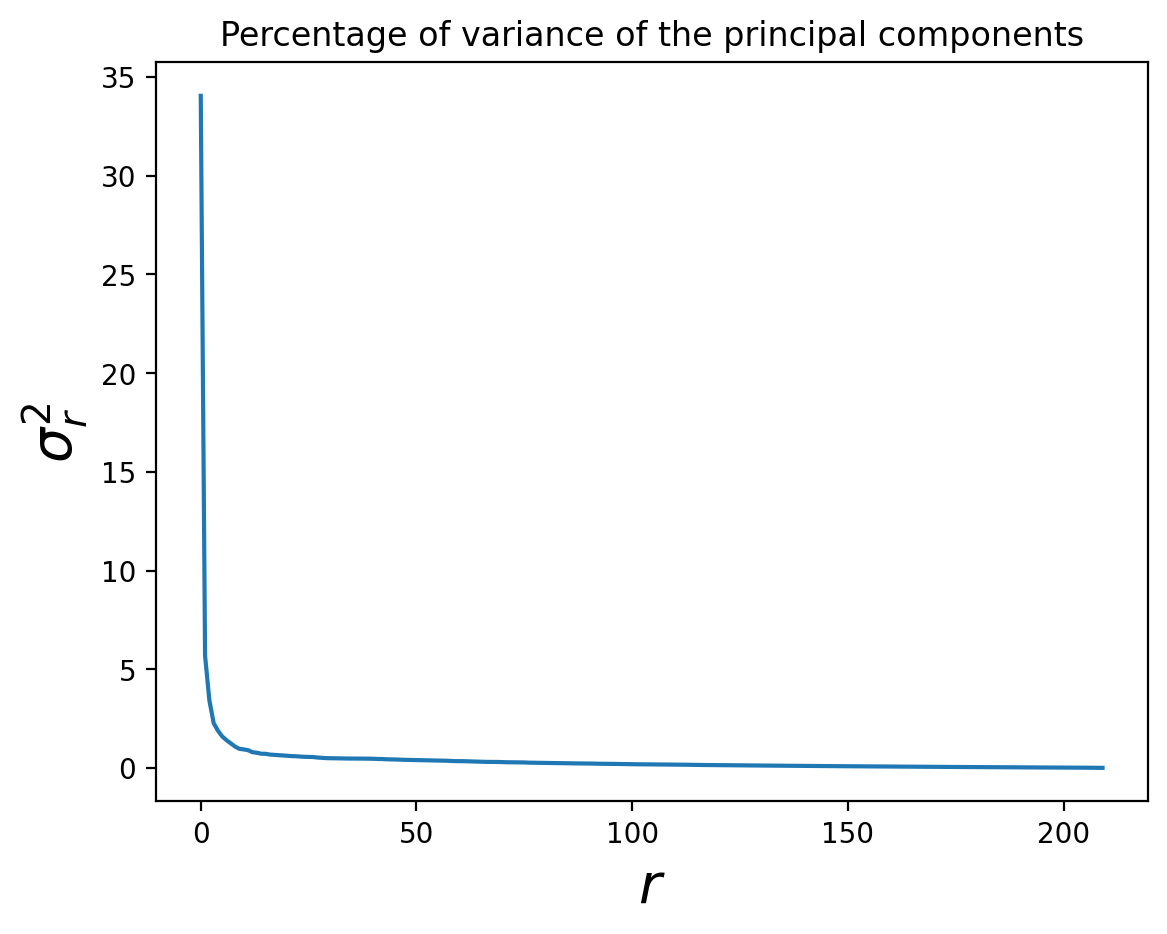

In [54]:
U,Sigma,Vt = np.linalg.svd(FBSpatial,full_matrices=False)

Sigma_squared = np.square(Sigma)
total_variance = total_variance = sum(Sigma_squared)

plt.plot(Sigma_squared*100/total_variance)
plt.title('Percentage of variance of the principal components')

plt.xlabel(r'$r$',size=20)
plt.ylabel(r'$\sigma_r^2$',size=20)

Now let's

1. Separate the portion of the data lying in the normal space from the amonalous space,
2. Identify the top 30 anomalous users (having the largest anomalous component), and
3. Plot their total number of likes against the set of all users.

Text(0, 0.5, 'Total number of likes')

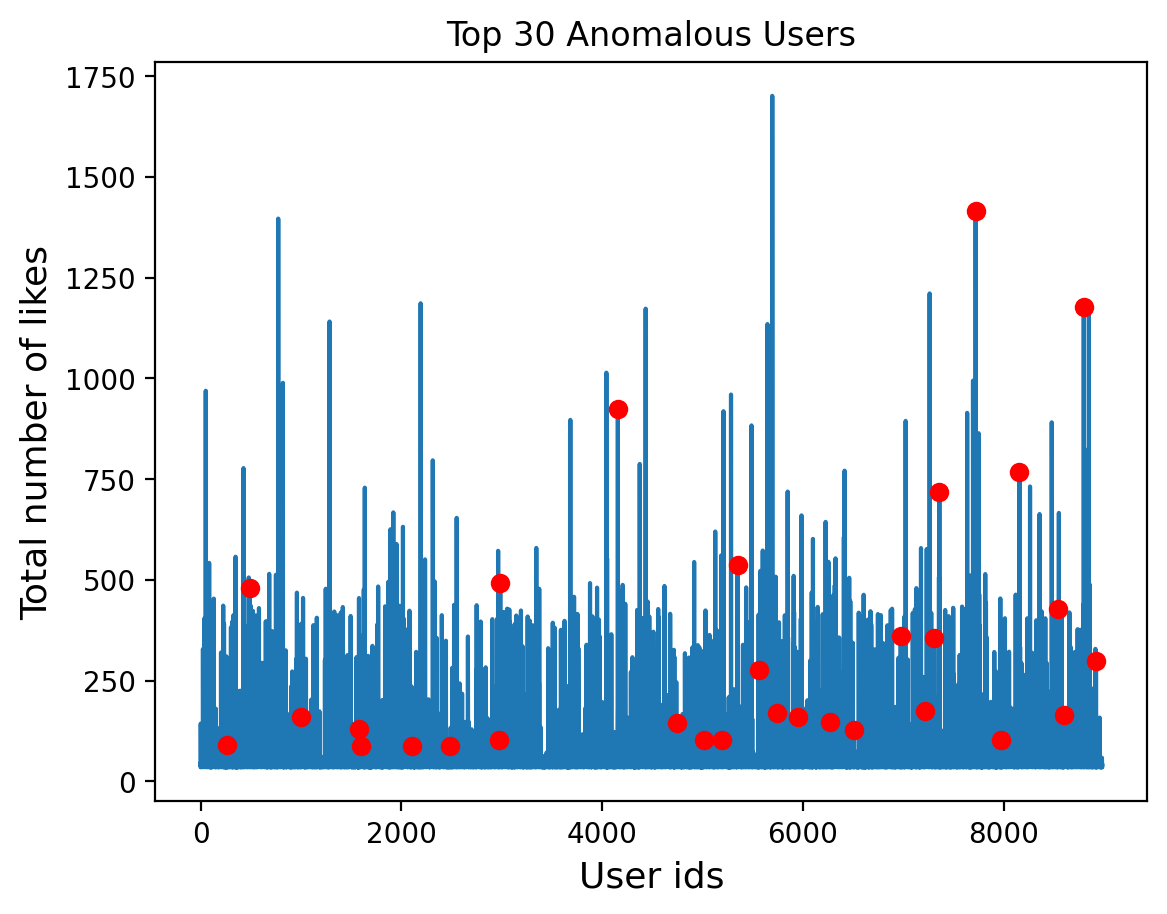

In [55]:
# components to consider
r=25

U_r = U[:,0:r]
Sigma_r = np.diag(Sigma[0:r])
V_r_t = Vt[0:r,:]

L = np.dot(U_r, np.dot(Sigma_r, V_r_t) )

O = FBSpatial - L
anomaly_scores = np.linalg.norm(O,axis=1)
# large = np.nonzero(Onorm>100))
# get top 30 anomalous users
anomSet = np.argsort(anomaly_scores)[-30:]


### Plotting
plt.plot(FBSnorm)
plt.plot(anomSet,FBSnorm[anomSet],'ro')
plt.title('Top 30 Anomalous Users')
plt.xlabel('User ids', size=13)
plt.ylabel('Total number of likes',size=13)

Anomalous users are **not simply those who deviate from the average user in terms of total likes**. We also discover anomalous users with usual number of total likes.

In paper[1] the authors can evaluate the performance of their anomaly detector, based on ground truth (some samples that represent true anomalous users and true normal users). Unfortunately, we do not have the ground-truth, so we cannot evaluate the quality of our anomaly detection

### Example 3: Facebook Temporal Likes

This data consists of the number of 'Likes' for each of 9000 users, over 6 months, on a daily basis

**Rows are users, Columns are days.**

The goal is again to find anomalous users (by looking at their temporal activity instead of their likes across categories)

First we'll look at the singular values.

Text(0, 0.5, 'Normalized $\\sigma_k^2$')

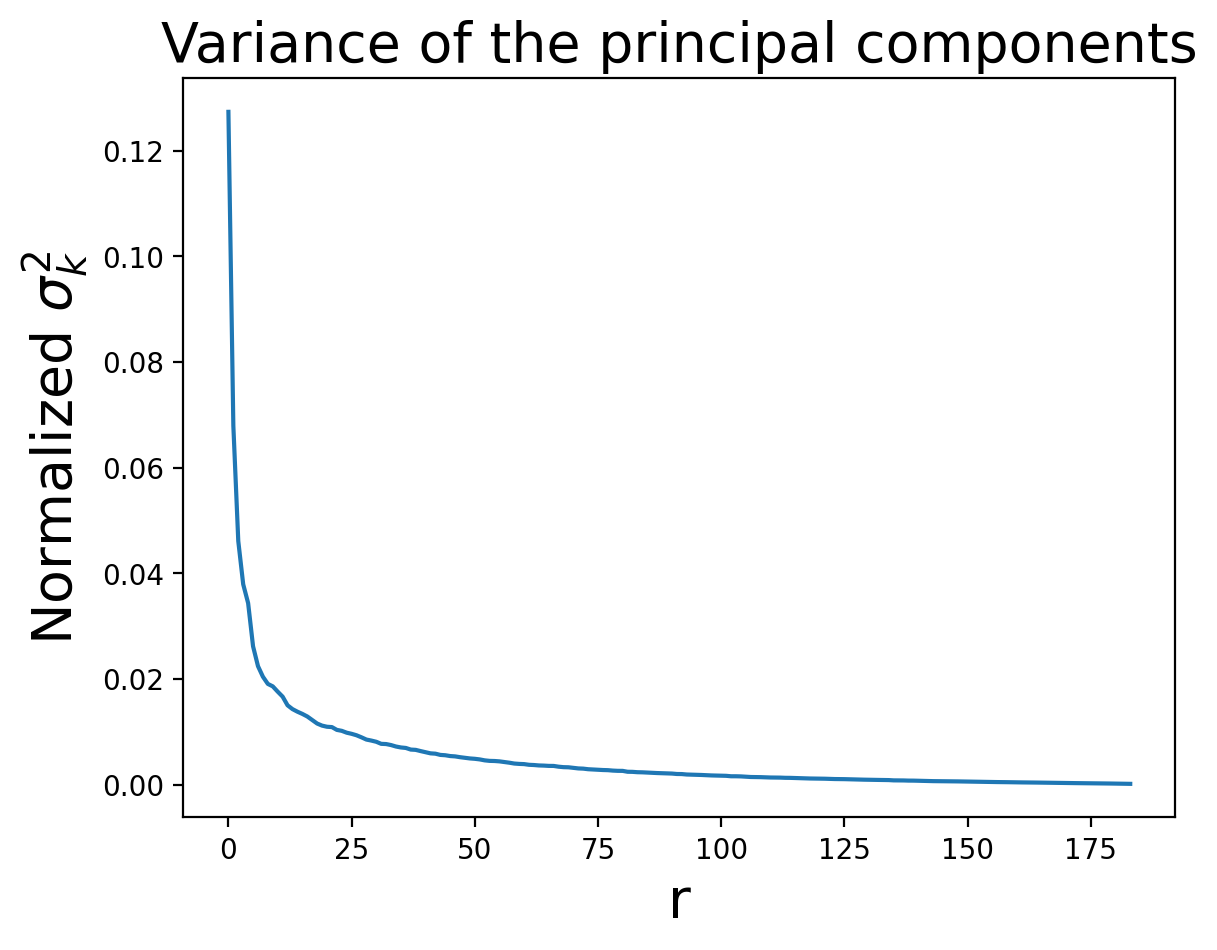

In [56]:
data = np.loadtxt('data/social/data/temporal_data.txt')
FBTemporal_orig = data[:,1:]

scaler = StandardScaler()
FBTemporal = scaler.fit(FBTemporal_orig)
FBTemporal = scaler.transform(FBTemporal_orig)

FBTnorm = np.linalg.norm(FBTemporal,axis=1,ord=1)
U,Sigma,Vt = np.linalg.svd(FBTemporal,full_matrices=False)


Sigma_squared = np.square(Sigma)
total_variance = total_variance = sum(Sigma_squared)



### Plotting
plt.plot(Sigma_squared/total_variance)
plt.title('Variance of the principal components', size=20)
plt.xlabel('r', size=20)
plt.ylabel(r'Normalized $\sigma_k^2$', size=20)

In [57]:
r=24 # Number of components we consider

U_r = U[:,0:r]
Sigma_r = np.diag(Sigma[0:r])
V_r_t = Vt[0:r,:]

L = np.dot(U_r, np.dot(Sigma_r, V_r_t) )

O = FBTemporal - L
anomaly_scores = np.linalg.norm(O,axis=1)

# get top 30 anomalous users
anomSet = np.argsort(anomaly_scores)[-30:]



Now let's look at anomalous and normal users.   

Text(0, 0.5, 'Total likes')

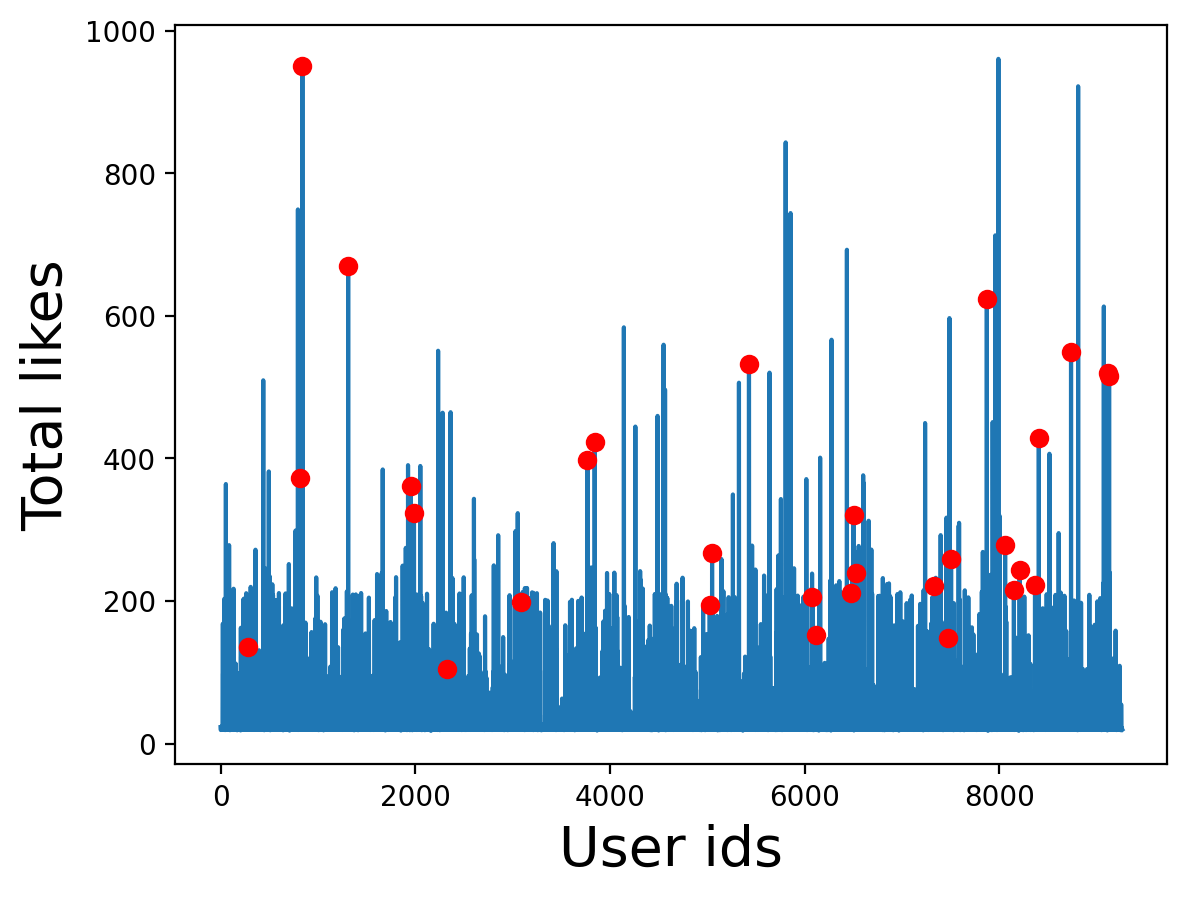

In [58]:
### Plotting
plt.plot(FBTnorm)
plt.plot(anomSet,FBTnorm[anomSet],'ro')
plt.xlabel('User ids', size=20)
plt.ylabel('Total likes', size=20)

## Bibliography

The results in this lecture are mostly self-contained.   However here are some papers that show various aspects of using these ideas in practice.
<table>
  <tr>
<td valign="baseline" align="left" class="p">
[1]
 Bimal Viswanath, Muhammad Ahmad Bashir, Mark Crovella, Saikat Guha, Krishna Gummadi, Balachander Krishnamurthy and Alan Mislove (2014).<br><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/usesec14-facebook-subspace.pdf">Towards Detecting Anomalous User Behavior in Online Social Networks.</a><br>In: <em>Proceedings of USENIX Security</em>. San Diego, CA. <a href="http://dx.doi.org/TBD">
	doi:TBD</a></td></tr>

<tr>
<td valign="baseline" align="left" class="p">
[2]
Gonca Gürsun and Mark Crovella (2012).<br><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/imc12-tm-completion.pdf">On Traffic Matrix Completion in the Internet.</a><br>In: <em>Proceedings of the Internet Measurement Conference (IMC)</em>. Boston, MA. <a href="http://dx.doi.org/10.1145/2398776.2398818">
	doi:10.1145/2398776.2398818</a></td></tr>

<tr>
<td valign="baseline" align="left" class="p">
[3]
Vineet Bharti, Pankaj Kankar, Lokesh Setia, Gonca Gürsun, Anukool Lakhina and Mark Crovella (2010).<br><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/conext10-invisible.pdf">Inferring Invisible Traffic.</a><br>In: <em>Proceedings of CoNEXT</em>. <a href="http://dx.doi.org/10.1145/1921168.1921197">
</td></tr>

<tr>
<td valign="baseline" align="left" class="p">
[4]
David B. Chua, Eric D. Kolaczyk and Mark Crovella (2006).<br><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/Network_Kriging.pdf">Network Kriging.</a><br>In: <em>IEEE Journal on Selected Areas in Communications, Special Issue on Sampling the Internet</em>, 24(12):2263--2272.
</td></tr>

<tr>
<td valign="baseline" align="left" class="p">
[5]
Anukool Lakhina, Mark Crovella and Christophe Diot (2005).<br><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/flocon05.pdf">Detecting Distributed Attacks using Network-Wide Flow Traffic.</a><br>In: <em>Proceedings of FloCon 2005 Analysis Workshop</em>.
</td></tr>

<tr>
<td valign="baseline" align="left" class="p">
[6]
Anukool Lakhina, Mark Crovella and Christophe Diot (2005).<br><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/sigc05-mining-anomalies.pdf">Mining Anomalies Using Traffic Feature Distributions.</a><br>In: <em>Proceedings of ACM SIGCOMM 2005</em>. pp. 217--228. <br><div class="note"><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/mining-anomalies-TR.pdf">
			[ Earlier (Full) Version, published as BUCS Technical Report BUCS-TR-2005-002 ]
                    </a></div>
</td></tr>

<tr>
<td valign="baseline" align="left" class="p">
[7]
Anukool Lakhina, Mark Crovella and Christophe Diot (2004).<br><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/imc04-characterizing-network-wide.pdf">Characterization of Network-Wide Anomalies in Traffic Flows.</a><br>In: <em>Proceedings of the ACM/SIGCOMM Internet Measurement Conference</em>. pp. 201--206. </td>
</td></tr>

<tr>
<td valign="baseline" align="left" class="p">
[8]
Anukool Lakhina, Mark Crovella and Christophe Diot (2004).<br><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/sigc04-network-wide-anomalies.pdf">Diagnosing Network-Wide Traffic Anomalies.</a><br>In: <em>Proceedings of ACM SIGCOMM 2004</em>. pp. 219--230. </td></tr>

<tr>
<td valign="baseline" align="left" class="p">
[9]
Anukool Lakhina, Mark Crovella and Christophe Diot (2004).<br><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/troubleshooting-sigc04.pdf">Exploring the Subspace Method for Network-Wide Anomaly Diagnosis (Poster Paper).</a><br>In: <em>Proceedings of ACM SIGCOMM Workshop on Network Troubleshooting</em>. pp. 319. </td></tr>

<tr>
<td valign="baseline" align="left" class="p">
[10]
Anukool Lakhina, Konstantina Papagiannaki, Mark Crovella, Christophe Diot, Eric D. Kolaczyk and Nina Taft (2004).<br><a href="http://www.cs.bu.edu/faculty/crovella/paper-archive/sigm04-odflows.pdf">Structural Analysis of Network Traffic Flows.</a><br>In: <em>Proceedings of ACM SIGMETRICS / Performance 2004</em>. pp. 61--72. <br><div class="note"><a href="http://www.cs.bu.edu/techreports/pdf/2003-021-odflows.pdf">
			[ Earlier version. Published as BUCS Technical Report BUCS-TR-2003-021 and Sprint Research Report RR03-ATL-110708 ]
</td>
</tr>

<tr>
<td valign="baseline" align="left" class="p">
[11]
Härdle, W. K., & Simar, L. (2015). Applied multivariate statistical analysis, fourth edition. Applied Multivariate Statistical Analysis, Fourth Edition (4th ed.). https://doi.org/10.1007/978-3-662-45171-7
</td>
</tr>

<tr>
<td valign="baseline" align="left" class="p">
[12]
Singular Value Decomposition, https://online.stat.psu.edu/stat555/node/94/, STAT 555, Statistical Analysis of Genomics Data, PennState University.
</table>


